# Introduction to Mathematical Optimization
[![intro_to_optimization.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/intro_to_optimization.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/intro_to_optimization.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/intro_to_optimization.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/intro_to_optimization.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/intro_to_optimization.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/intro_to_optimization.ipynb)](https://colab.ampl.com)

Description: Basic introduction to optimization and AMPL via unconstrained optimization

Tags: ampl-lecture, amplpy, ampl, introduction, optimization, convexity, unconstrained

Notebook author: Gyorgy Matyasfalvi <<gyorgy@ampl.com>>

References:

* AMPL a Modeling Language for Mathematical Programming -- Robert Fourer et al.
* Linear Programming (Foundations and Extensions) -- Robert J. Vanderbei
* Introduction to Linear Optimization -- Dimitris Bertsimas et al.
* Convex Analysis and Optimization -- Dimitri P. Bertsekas et al.

In [1]:
# Install dependencies
%pip install -q amplpy pandas numpy matplotlib

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["open", "gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

In [3]:
# Import all necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import log, cos, sin, pi, sqrt

## Problem types
An optimization problem, in its most general form, can be expressed as follows:

$$
\begin{array}{lll}
&\min           & f(x)  &    \\
&\textrm{s.t.}  & x  \in \Omega,
\end{array}
$$ (eqn:opproblem)

In this equation, $ f: \mathbb{R}^n \rightarrow \mathbb{R} $ and $ \Omega \subset \mathbb{R}^n $.
We refer to $ f $ as the *objective function*, $ x \in \Omega $ as the *constraints*, and the vector $ x $ as the *decision variables*.
A vector $x \in \mathbb{R}^n$ satisfying all of the constraints (i.e. $x \in \mathbb{\Omega}$) is called a *feasible solution*.
A feasible solution $x^*$ that minimizes the objective function is called an *optimal feasible solution*, or simply, an *optimal solution*.

If $ \Omega $ is equal to $ \mathbb{R}^n $, we are dealing with an unconstrained optimization problem. These are **significantly easier** to solve compared to constrained optimization problems.

In our exploration of optimization problems, it's crucial to understand the nature of functions and constraints.
We need to distinguish between convex and non-convex problems, as well as between linear and non-linear ones.
While our primary focus in this training is on linear constrained optimization problems, we will initially delve into some non-linear and non-convex challenges to elucidate key concepts.


## Convex problems
Convex problems, particularly those that are smooth, are preferred for two main reasons:
1. They provide a guarantee of **global optimality**.
2. There are many efficient algorithms (implemented in various solvers) available for solving these problems.

A problem defined by the above equation (1) is considered convex if $ f $ is a convex function and $ \Omega $ is a nonempty closed convex set.

### Definition of convexity
**Convex set**: A subset $\Omega$ of $\mathbb{R}^n$ is called *convex* if
$$
\lambda x + (1-\lambda) y \in \Omega \qquad \forall x,y \in \Omega, \quad \forall \lambda \in [0,1]. \tag{2}
$$

**Geometrically**, the line segment connecting $x$ to $y$ must also lie within the set $\Omega$.


<br>
<br>

**Convex function**: Let $\Omega$ be a convex subset of $\mathbb{R}^n$. A function $\Omega : \mathbb{R}^n \rightarrow \mathbb{R}$ is convex if we have

$$
f(\lambda x + (1-\lambda) y) \leq \lambda f(x) + (1-\lambda) f(y) \qquad \forall x,y \in \Omega, \quad \forall \lambda \in [0,1]. \tag{3}
$$

**Geometrically**, the line segment connecting $(x, f (x))$ to $(y, f (y))$ must sit above the graph of $f$.

**Also geometrically**, a function is convex if and only if the area above its graph is convex.

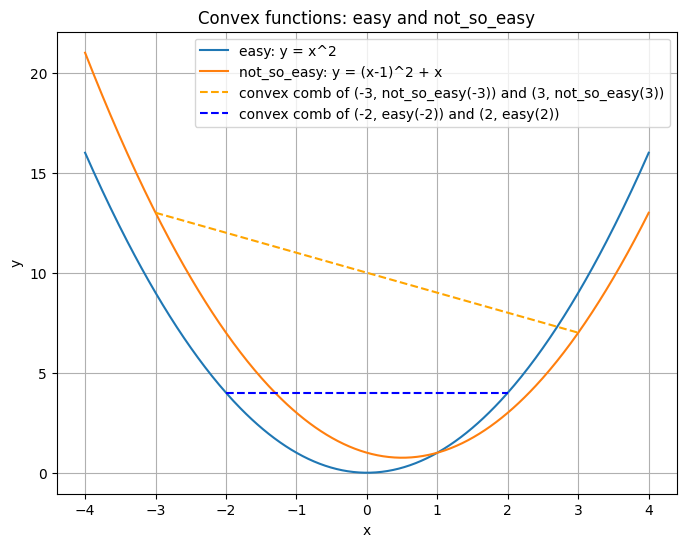

In [4]:
# Plot convex functions


# Define the functions
def easy(x):
    return x**2


def not_so_easy(x):
    return (x - 1) ** 2 + x


# Generate x values
x = np.linspace(-4, 4, 400)

# Generate y values
ye = easy(x)
yne = not_so_easy(x)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, ye, label="easy: y = x^2")
plt.plot(x, yne, label="not_so_easy: y = (x-1)^2 + x")

# Add a line that connects two points
x_not_so_easy = [-3, 3]
y_not_so_easy = [not_so_easy(-3), not_so_easy(3)]
plt.plot(
    x_not_so_easy,
    y_not_so_easy,
    color="orange",
    linestyle="--",
    label="convex comb of (-3, not_so_easy(-3)) and (3, not_so_easy(3))",
)
x_easy = [-2, 2]
y_easy = [easy(-2), easy(2)]
plt.plot(
    x_easy,
    y_easy,
    color="blue",
    linestyle="--",
    label="convex comb of (-2, easy(-2)) and (2, easy(2))",
)


plt.title("Convex functions: easy and not_so_easy")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

### Where/what is the minimum of the easy function? ;-)

### How about the not-so-easy function?

### Let's ask AMPL!

In [5]:
%%ampl_eval
reset; reset option;                # reset AMPL, this is needed for when we run the cell multiple times,
                                    # AMPL complains about redeclaration of entities.
var x;                              # Declare our variable
minimize not_so_easy: (x-1)^2 + x;  # Define our objective function
solve;                              # Attempt to solve

Error executing "solve" command:
No solver specified:  option solver is ''.


**Whoops!!! We always need to specify the solver before attempting to solve!**

In [6]:
%%ampl_eval
option solver ipopt;                        # Use Ipopt as our solver
solve;                                      # Issue solve command and send the problem, this time, to Ipopt
                                            # After succesful completion of solve AMPL retrieves the solutions from Ipopt
print;                                      # Add a new line (only for formatting purposes)
print "Optimum: (", x, not_so_easy, ")";    # Let's also print the solution!

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

In [7]:
assert (
    ampl.solve_result == "solved"
), (
    ampl.solve_result
)  # Checks that the problem was actually solved and the solver did not fail

### Let's try a more difficult case

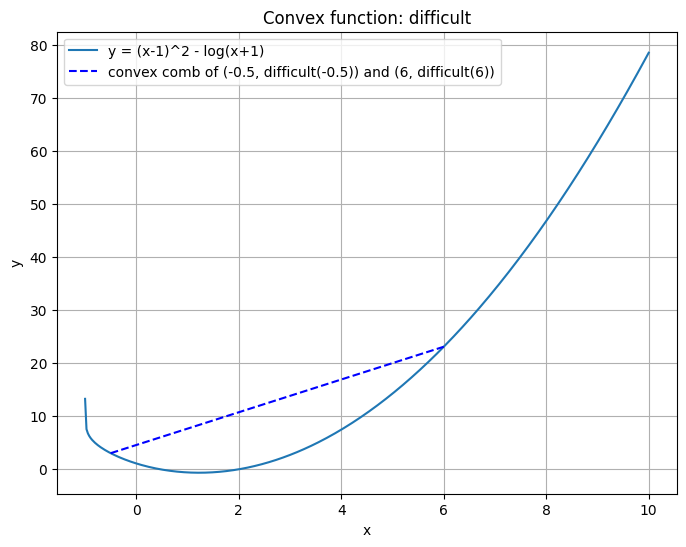

In [8]:
# Draw a difficult to optimize convex function


# Define the function
def difficult(x):
    return (x - 1) ** 2 - log(x + 1)


# Generate x values
x = np.linspace(-0.9999, 10, 400)

# Generate y values
y = [difficult(i) for i in x]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, label="y = (x-1)^2 - log(x+1)")

# Add a line that connects two points
x_difficult = [-0.5, 6]
y_difficult = [difficult(-0.5), difficult(6)]
plt.plot(
    x_difficult,
    y_difficult,
    color="blue",
    linestyle="--",
    label="convex comb of (-0.5, difficult(-0.5)) and (6, difficult(6))",
)

plt.title("Convex function: difficult")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

### How do we know function `difficult` is convex?
1. We can apply the definition.
2. We can examine the epigraph of the function (or in this simple case just look at the graph of the function) and make conclusions based off of that.
3. Also, if we know that $x^2$ and $-\log(x)$ are convex then there are some powerful theorems we can use to help us recognize convex functions:

**Sum of convex functions is convex:** Let $f_i: \mathbb{R}^n \rightarrow \mathbb{R}$, $i = 1,\ldots,m$, let $\lambda_1, \ldots, \lambda_m$ be positive scalars, and consider the function $g: \mathbb{R}^n \rightarrow \mathbb{R}$ given by:

$$
\begin{equation}
g(x) = \lambda_1 f_1(x) + \ldots + \lambda_m f_m(x).
\end{equation}
$$ (eqn:4)

If $f_1, \ldots, f_m$ are convex, then $g$ is also convex.


**Transformations preserving convexity of domain:** Let $f: \mathbb{R}^m \rightarrow \mathbb{R}$ be a given function, let $A \in \mathbb{R}^{m \times n}$ matrix, and consider the function $g: \mathbb{R}^n \rightarrow \mathbb{R}$ given by:

$$
\begin{equation}
g(x) = f(Ax).
\end{equation}
$$ (eqn:5)

If $f$ is convex, then $g$ is also convex (e.g norm functions are convex and so are least squares type problems, e.g. $\min_{x \in \mathbb{R}^n} || Ax -b||^2_2$).

**Maximum of convex functions is convex:** Let $f_i: \mathbb{R}^n \rightarrow \mathbb{R}$, $i \in I$, where $I$ is an arbitrary index set, and consider the function $g: \mathbb{R}^n \rightarrow \mathbb{R}$ given by:

$$
\begin{equation}
g(x) = \max_{i \in I} f_i(x).
\end{equation}
$$ (eqn:6)

If $f_i, \; i \in I$, are convex, then $g$ is also convex.

## Let's get ready for our first exercise with some basic AMPL syntax
More details later (or in the [AMPL book](https://ampl.com/learn/ampl-book/), or just ask ;-)

### Variable declarations
To declare our variables in AMPL, we first use the `var` keyword followed by the variable name, optional attributes, and a semicolon.
It is also worth mentioning that by default, AMPL initializes all variables to zero unless an initial value is provided via an attribute (e.g. `var x := 1;` in which case the initial value of `x` becomes 1).
This will be important to keep in mind later on when we discuss computing the value of expressions that involve variables.

**Reminder:** Each AMPL statement ends with a semicolon.

### Objective declarations
To specify an objective function in AMPL, we first have to specify the direction of optimization via the keywords `maximize` or `minimize`, which is followed by a name, a colon, an expression involving our variables, and a semicolon.

**Reminder:** Variables must be declared before they can be used in an expression.

It's good practice to use a descriptive name for the objective function, such as `profit`, which reflects what we're trying to optimize.
In the next example you might choose to use the `difficult` qualifier.
The expression should be a mathematical formula involving our variables that reflect the goal of the optimization problem.

## EXERCISE 1
1. Create a code cell below.

2. Start with the magic: `%%ampl_eval`

3. Reset the state of the AMPL interpreter with `reset;` and `reset option;`.

4. Then use the AMPL keywords `var` and `minimize`, as well as the built-in function `log()` to formulate the model that minimizes `difficult()` (the built-in AMPL function `log()` is base $e$ just like the Python function `log()`).

5. Compute the minimum using the `ipopt` solver.

6. Then print the solution using AMPL's `print` command.

## SOLUTION

In [9]:
%%ampl_eval
reset; reset option;                # reset AMPL, this is needed for when we run the cell multiple times,
                                    # AMPL complains about redeclaration of entities.
var x;                              # Declare our variable
minimize difficult: (x-1)^2 - log(x+1);  # Define our objective function
option solver ipopt;                # Use Ipopt as our solver
solve;                              # Attempt to solve
print;                              # Add a new line (only for formatting purposes)
print "Optimum: (", x, difficult, ")";    # Let's also print the solution!

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

In [10]:
assert (
    ampl.solve_result == "solved"
), (
    ampl.solve_result
)  # Checks that the problem was actually solved and the solver did not fail

## Non-convex functions
We've consistently found the optimal solution without much difficulty.
This is expected since we've been dealing with convex smooth functions.
Local non-linear solvers like Ipopt are well-equipped for these types of problems.
Now, let's examine a non-convex function and observe the outcome.

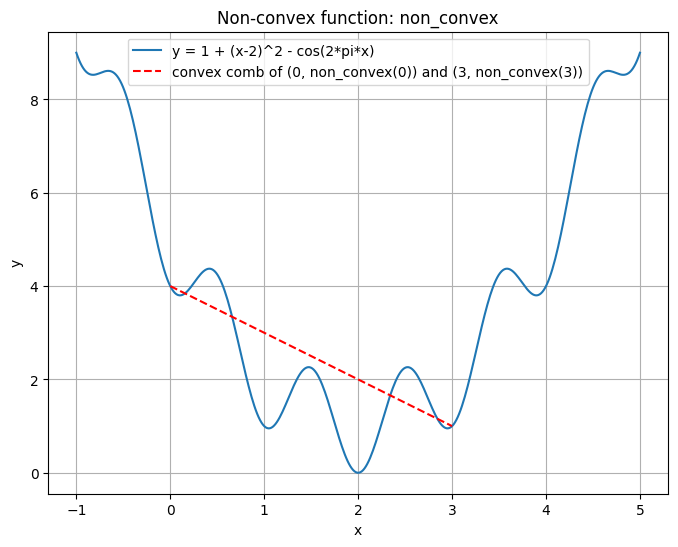

In [11]:
# Draw a non-convex function


# Define the function
def non_convex(x):
    return 1 + (x - 2) ** 2 - cos(2 * pi * x)


# Generate x values
x = np.linspace(-1, 5, 400)

# Generate y values
y = [non_convex(i) for i in x]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, label="y = 1 + (x-2)^2 - cos(2*pi*x)")

# Add a line that connects two points
x_non_convex = [0, 3]
y_non_convex = [non_convex(0), non_convex(3)]
plt.plot(
    x_non_convex,
    y_non_convex,
    color="red",
    linestyle="--",
    label="convex comb of (0, non_convex(0)) and (3, non_convex(3))",
)

plt.title("Non-convex function: non_convex")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

## For the second exercise you will need a new AMPL entity called a parameter

### Parameter declarations
For the second exercise, we will declare $\pi$ as a parameter in AMPL.
To do this, we use the keyword `param`, followed by the parameter name. While assigning an initial is generally optional, in this instance we provide one.
The declaration is then concluded with a semi-colon.

## EXERCISE 2
1. Create a code cell below.

2. Start with the magic: `%%ampl_eval`

3. Reset the state of the AMPL interpreter with `reset;` and `reset option;`.

4. Then use the following parameter definition: `param pi = 4 * atan(1);` to declare $\pi$.

5. Next, use keywords `var` and `minimize`, as well as the built-in function `cos()` to formulate the model that minimizes `non_convex()`.

5. Compute the minimum using the `ipopt` solver.

6. Then print the solution using AMPL's `print` command.

## SOLUTION

In [12]:
%%ampl_eval
reset; reset option;                # reset AMPL, this is needed for when we run the cell multiple times,
                                    # AMPL complains about redeclaration of entities.
param pi = 4 * atan(1);             # Define pi
var x;                              # Declare our variable
minimize non_convex: 1 + (x-2)^2 - cos(2*pi*x);  # Define our objective function
option solver ipopt;                # Use Ipopt as our solver
solve;                              # Attempt to solve
print;                              # Add a new line (only for formatting purposes)
print "Optimum: (", x, non_convex, ")";    # Let's also print the solution!

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

In [13]:
assert (
    ampl.solve_result == "solved"
), (
    ampl.solve_result
)  # Checks that the problem was actually solved and the solver did not fail

## Did we find the optimum?
Let's check by plotting the results.

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

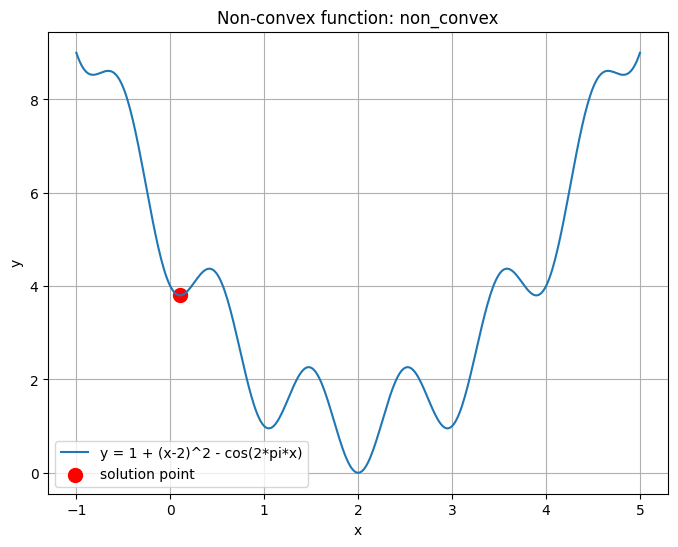

In [14]:
# Now instead of using magic cells we will be using the AMPL API directly
ampl = AMPL()  # Instantiate an AMPL object
ampl.reset()  # Reset AMPL
# Load the model
ampl.eval(
    r"""
    var x;
    param pi = 4 * atan(1);
    minimize non_convex: 1 + (x-2)^2 - cos(2*pi*x);
    """
)
ampl.solve(solver="ipopt")  # Solve the problem with Ipopt
sol_df = ampl.get_data(
    "x, non_convex"
).to_pandas()  # Retrieve the solution (we can retrieve x and non_convex because they are indexed over the same set).


# Define the function
def non_convex(x):
    return 1 + (x - 2) ** 2 - cos(2 * pi * x)


# Generate x values
x = np.linspace(-1, 5, 400)

# Generate y values
y = [non_convex(i) for i in x]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, label="y = 1 + (x-2)^2 - cos(2*pi*x)")

# Plot the values in sol_df
plt.scatter(
    sol_df["x"], sol_df["non_convex"], color="red", s=100, label="solution point"
)

plt.title("Non-convex function: non_convex")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
assert ampl.solve_result == "solved", ampl.solve_result

## As expected we only found a local optimum
To address this, let's switch to a global solver.
Global solvers excel at managing non-convex functions characterized by multiple local optima.
In situations where pinpointing the global optimum is crucial, these solvers come into their own.
However, it's worth noting that they typically operate at a slower speeds compared to local solvers.

## EXERCISE 3
1. Go back to the previous code cell and change the solver to `gurobi`, then re-run the cell.

2. What happens if you change the default starting value of `x := 0` to `x := 1.5`?

## SOLUTION

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 4.440892099e-16
3 simplex iterations
1 branching node
absmipgap=4.44089e-16, relmipgap=0


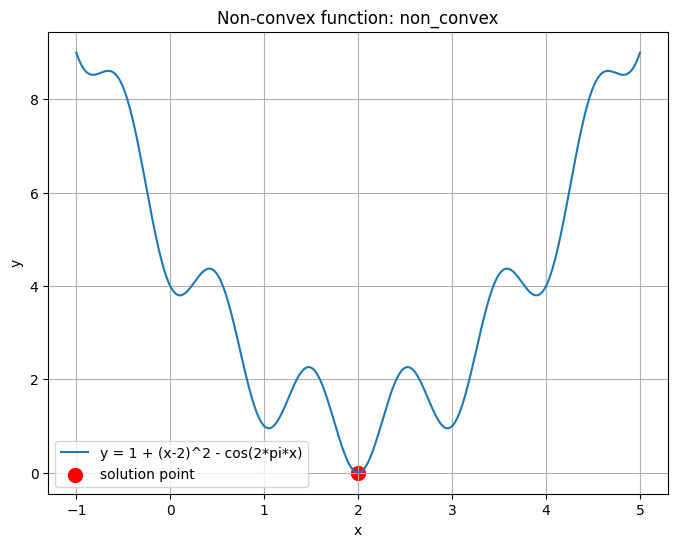

In [16]:
# Now instead of using magic cells we will be using the AMPL API directly
ampl = AMPL()  # Instantiate an AMPL object
ampl.reset()  # Reset AMPL
# Load the model
ampl.eval(
    r"""
    var x;
    param pi = 4 * atan(1);
    minimize non_convex: 1 + (x-2)^2 - cos(2*pi*x);
    """
)
ampl.solve(solver="gurobi")  # Solve the problem with Gurobi
sol_df = ampl.get_data(
    "x, non_convex"
).to_pandas()  # Retrieve the solution (we can retrieve x and non_convex because they are indexed over the same set).


# Define the function
def non_convex(x):
    return 1 + (x - 2) ** 2 - cos(2 * pi * x)


# Generate x values
x = np.linspace(-1, 5, 400)

# Generate y values
y = [non_convex(i) for i in x]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, label="y = 1 + (x-2)^2 - cos(2*pi*x)")

# Plot the values in sol_df
plt.scatter(
    sol_df["x"], sol_df["non_convex"], color="red", s=100, label="solution point"
)

plt.title("Non-convex function: non_convex")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

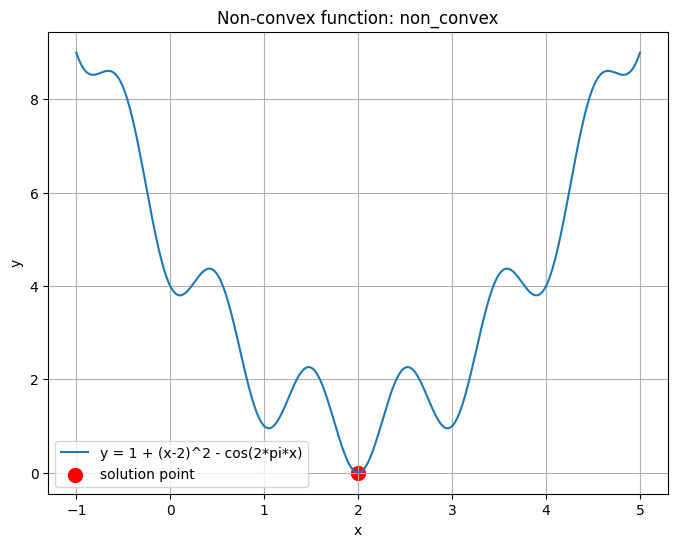

In [17]:
# Now instead of using magic cells we will be using the AMPL API directly
ampl = AMPL()  # Instantiate an AMPL object
ampl.reset()  # Reset AMPL
# Load the model
ampl.eval(
    r"""
    var x := 1.5;                                             # Give x an initial value other than 0 (AMPL's default is 0)
    param pi = 4 * atan(1);
    minimize non_convex: 1 + (x-2)^2 - cos(2*pi*x);
    """
)
ampl.solve(solver="ipopt")  # Solve the problem with Ipopt
assert ampl.solve_result == "solved", ampl.solve_result
sol_df = ampl.get_data(
    "x, non_convex"
).to_pandas()  # Retrieve the solution (we can retrieve x and non_convex because they are indexed over the same set).


# Define the function
def non_convex(x):
    return 1 + (x - 2) ** 2 - cos(2 * pi * x)


# Generate x values
x = np.linspace(-1, 5, 400)

# Generate y values
y = [non_convex(i) for i in x]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, label="y = 1 + (x-2)^2 - cos(2*pi*x)")

# Plot the values in sol_df
plt.scatter(
    sol_df["x"], sol_df["non_convex"], color="red", s=100, label="solution point"
)

plt.title("Non-convex function: non_convex")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

## EXERCISE 4
1. Let's return to our difficult function and try solving it with another solver called `highs`. Did we find the optimum?

## SOLUTION

In [18]:
ampl = AMPL()  # Instantiate an AMPL object
ampl.eval(
    r"""
            var x;                                              # Declare our variable
            minimize difficult: (x-1)^2 - log(x+1);             # Define our objective function
          """
)

ampl.solve(solver="highs")  # Attempt to solve
assert ampl.solve_result == "solved", ampl.solve_result

HiGHS 1.10.0: 
------------ WARNINGS ------------
  Argument domain of a 'Log'
has been reduced to [0.000001, 1000000.000000] for numerical reasons
(partially controlled by cvt:plapprox:domain.)
  An expression of type 'Log' has been
piecewise-linearly approximated. Set cvt:plapprox:reltol
to control precision (currently 0.010000).
HiGHS 1.10.0: optimal solution; objective -0.7429247297
0 simplex iterations
0 barrier iterations
 
------------ WARNINGS ------------
  Argument domain of a 'Log'
has been reduced to [0.000001, 1000000.000000] for numerical reasons
(partially controlled by cvt:plapprox:domain.)
  An expression of type 'Log' has been
piecewise-linearly approximated. Set cvt:plapprox:reltol
to control precision (currently 0.010000).


HiGHS is a solver adept at tackling Mixed Integer Programming (MIP) and Quadratic Programming (QP) problems, which means it can efficiently handle linear programming, integer programming, and quadratic programming challenges.
However, it encounters limitations with our objective function, which includes a logarithmic term.


As HiGHS cannot directly process the logarithmic element, the [MP solver driver](https://mp.ampl.com) compensates by approximating this term using piecewise linear functions.
The WARNING message you encountered is to alert you that such an approximation has been applied.


Earlier versions of the HiGHS driver, including version 20240320, were unable to find a solution to this problem despite the approximation. Current version of HiGHS manages to find an optimal solution to the approximated problem:

```HiGHS 1.10.0: optimal solution; objective -0.7429247297```

## Programmatically checking the solve result status
The following code segment demonstrates how to verify programmatically whether a satisfactory solution has been attained.

In [19]:
ampl = AMPL()  # Instantiate an AMPL object
ampl.eval(
    r"""
            var x;                                              # Declare our variable
            minimize difficult: (x-1)^2 - log(x+1);             # Define our objective function
          """
)

ampl.solve(solver="highs")  # Attempt to solve
print(
    ampl.option["solve_result_table"]
)  # Print the solve result table, this will inform us of the various solution codes.
result_df = ampl.get_data("solve_result_num").to_pandas()  # Retrieve solution status
# Check if the problem was solved if not print warning
srn = result_df["solve_result_num"].iloc[0]
if srn != 0:  # failure
    print(f"Warning: Problem not solved to optimality❗\n\t solve_result_num = {srn}")
else:  # solved!
    print(f"Problem solved optimally! 🚀\n\t solve_result_num = {srn}")

HiGHS 1.10.0: 
------------ WARNINGS ------------
  Argument domain of a 'Log'
has been reduced to [0.000001, 1000000.000000] for numerical reasons
(partially controlled by cvt:plapprox:domain.)
  An expression of type 'Log' has been
piecewise-linearly approximated. Set cvt:plapprox:reltol
to control precision (currently 0.010000).
HiGHS 1.10.0: optimal solution; objective -0.7429247297
0 simplex iterations
0 barrier iterations
 
------------ WARNINGS ------------
  Argument domain of a 'Log'
has been reduced to [0.000001, 1000000.000000] for numerical reasons
(partially controlled by cvt:plapprox:domain.)
  An expression of type 'Log' has been
piecewise-linearly approximated. Set cvt:plapprox:reltol
to control precision (currently 0.010000).

0	solved
100	solved?
200	infeasible
300	unbounded
400	limit
500	failure

Problem solved optimally! 🚀
	 solve_result_num = 0
